In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Constants we will use throughout

In [2]:
# Paths to data and names of data files
DATA_PATH = "assignment1data/assignment1data/"
CONFIRMED_CASES = "covid_confirmed_usafacts.csv"
DEATHS = "covid_deaths_usafacts.csv"
POP_FACTS = "covid_county_population_usafacts.csv"

# read the data files into dataframes
cases_df = pd.read_csv(DATA_PATH + CONFIRMED_CASES)
deaths_df = pd.read_csv(DATA_PATH + DEATHS)
pop_df = pd.read_csv(DATA_PATH + POP_FACTS)

NON_NUMERIC_COLS = 3 # number of leading non numeric columns in deaths/new cases data
FIG_SIZE = (10, 6) # adjust the figure size depending on your display

### Define some functions we will be using

In [3]:
def cumm_to_daily(statistic_df, date_offset):
    """Takes in a raw statistic(deaths/cases) dataframe object with aggregate daily 
        amounts and returns individual daily counts.
    input   dataframe of statistic of format:
            index=[None], keys=[countyFIPS, County Name, State, StateFIPS, Cases by date (aggregated), ...]
    returns dataframe with nonzero statistic. That Dataframe is of format:
            index=[None], keys=[countyFIPS, County Name, State, StateFIPS, Cases by date (individual), ...]
    """
    # shift left to zero out the data (population, FIPS, etc), then right to perform the difference
    shifted = statistic_df.shift(periods=-date_offset, fill_value=0, axis='columns').shift(periods=date_offset+1, fill_value=0, axis='columns')
    
    # get the delta of total cases each day (cases per day)
    statistic_df.iloc[:, date_offset:] = statistic_df.iloc[:, date_offset:] - shifted.iloc[:, date_offset:]
    
    return statistic_df

In [4]:
def sum_state(statistic_df, index):
    """Takes in a raw statistic(deaths/cases) dataframe object with aggregate daily 
       amounts and returns individual daily counts and sums all by index (parameter). Sets the value of 
       the index paramter as the dataframe index.
       eg. sum_state(cases_df, 'State') will return a cases_df where indexes are the states. States with 
       multiple values are aggregated into a single value (sum). 
    input   dataframe with nonzero statistic. That Dataframe is of format:
                index=[index(parameter)], keys=[Cases by date (individual), ...]
    returns dataframe with nonzero statistic. That Dataframe is of format:
                index=[index(parameter)], keys=[Cases by date (individual), ...]
    """
    dropped_indexes = ['State', 'StateFIPS', 'County Name', 'countyFIPS'] # drop columns we don't want (error is thrown)
    dropped_indexes.remove(index) # we don't want to drop the index
    
    statistic_by_day = cumm_to_daily(statistic_df.copy(), NON_NUMERIC_COLS+1) # data is cummulative with the day before, get the daily counts
    statistic_by_day.set_index([index], inplace=True)
    statistic_by_day.drop(dropped_indexes, axis=1, inplace=True)
    
    statistic_by_day = statistic_by_day.groupby(statistic_by_day.index).agg(sum) # sum over common indices

    return statistic_by_day

In [5]:
def trim_incomplete_data(statistic_df):
    """We trim out incomplete weeks (which turn out to be the first week only for this dataset). 
       Drops the first index, which is the first week.
    input   dataframe of statistic of format:
                index=[Weeks], keys=[countyFIPS, County Name, State, or StateFIPS]
    returns dataframe with nonzero statistic. That Dataframe is of format:
                index=[Dates - first date], keys=[countyFIPS, County Name, State, or StateFIPS]
    """
    statistic_df.drop(statistic_df.index[0], inplace=True)
    return statistic_df

In [6]:
def weekly_sum(statistic_df, index='State'):
    """Takes in a raw statistic(deaths/cases) dataframe object with aggregate daily 
       amounts and returns weekly sum of the index type.
       eg. weekly_sum(cases_df, 'State') will return a cases_df where indexes are sums of the states for 
       each week and columns are the weekly sums.
    input   dataframe of statistic of format:
                index=[None], keys=[countyFIPS, County Name, State, StateFIPS, Cases by date (aggregated), ...]
            index we will use as the index (optional)
    returns dataframe with nonzero statistic. That Dataframe is of format:
                index=[index(parameter)], keys=[Cases by week (sum), ...]
    """
    daily_sum = sum_state(statistic_df, index).T # get the daily counts and remove unneeded columns
    daily_sum.index = pd.to_datetime(daily_sum.index) # convert indices to dates
    statistic_by_week = daily_sum.resample('W-MON', label='left', closed='left').sum() # convert daily counts to weekly sums
    statistic_by_week = trim_incomplete_data(statistic_by_week)
    return statistic_by_week.T

In [7]:
def plot_state(state_str, statistic_df, mode='default'):
    """Outputs a plot of the weekly number (non-cummulative) of new cases or deaths for that state. 
       New cases or number of deaths depends on what the dataframe is that is passed in.
    input   a string corresponding to any value of the "State" column of for either deaths or 
                cases dataset.
            statistic_df instance of a dataframe for the statistic (either deaths or cases) dataset.
            mode used to determine how to title the graph (if multiple states on same graph)
    """
    state_df = statistic_df.loc[state_str]
    state_df.index = state_df.index.date
    
    if mode=='default': # for individual states
        plt.figure(figsize=FIG_SIZE)
        plot = sns.barplot(x=state_df.index, y=state_df.values, color='blue', ci=None) # remove ci=None to add back the confidence interval
        plot.set(xlabel = 'Date', ylabel = 'Counties with peak cases')
        plt.xticks(rotation=70)
        plt.tight_layout()
        plot.set(xlabel = 'Date', ylabel = 'Statistic count', title=state_str)
        plt.show()
    else: # if we want to plot multiple states, use a line plot.
        state_df.plot(ylabel='Count', label=state_str, title='All', legend=True, figsize=FIG_SIZE)

# Problem 1
Plot the weekly number of new cases of covid in the following states: California, Oregon,
Washington, and Nevada. A week starts on Monday and ends on Sunday.

In [15]:
cases_state_sum = weekly_sum(cases_df)
cases_state_sum.loc[['CA', 'NV', 'OR', 'WA']] # give a sample of ALL the data

,2020-01-27,2020-02-03,2020-02-10,2020-02-17,2020-02-24,2020-03-02,2020-03-09,2020-03-16,2020-03-23,2020-03-30,...,2020-11-30,2020-12-07,2020-12-14,2020-12-21,2020-12-28,2021-01-04,2021-01-11,2021-01-18,2021-01-25,2021-02-01
State,,,,,,,,,,,,,,,,,,,,,
CA,2,2,2,4,10,109,490,1484,4602,8649,...,142436,218943,294428,259513,268459,279701,271512,166676,134177,92578
NV,0,0,0,0,0,4,22,168,732,910,...,17205,17781,14305,14139,15021,16743,12797,9197,7338,5681
OR,0,0,0,0,1,13,25,122,387,519,...,10376,6925,8887,6514,7088,8939,8411,5581,4891,4409
WA,0,0,0,0,10,111,647,1227,2900,3121,...,14747,24612,20541,7589,25059,8749,19780,16421,11399,8549


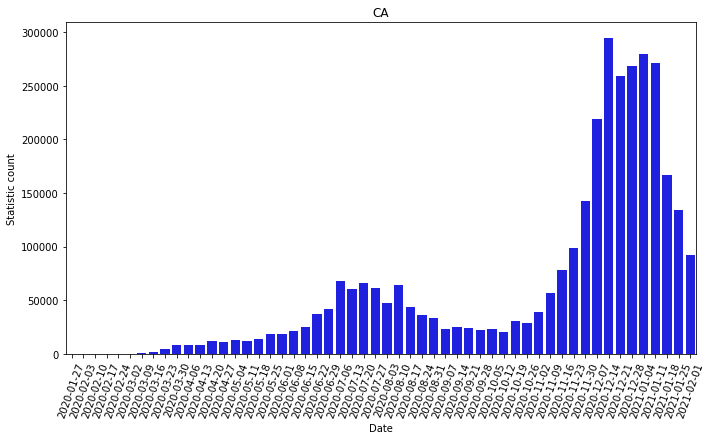

In [16]:
plot_state('CA', cases_state_sum)

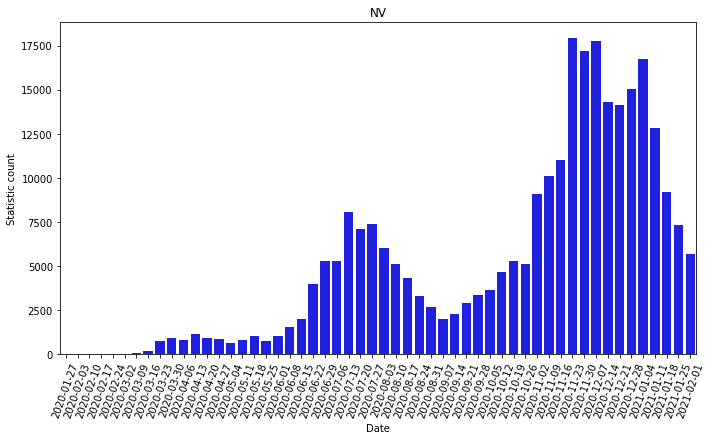

In [17]:
plot_state('NV', cases_state_sum)

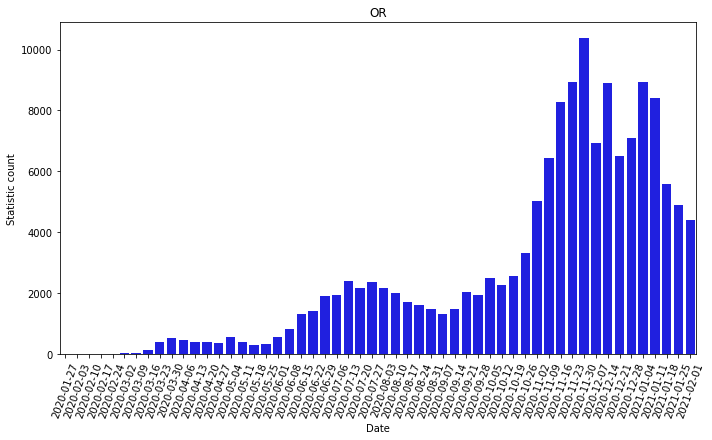

In [18]:
plot_state('OR', cases_state_sum)

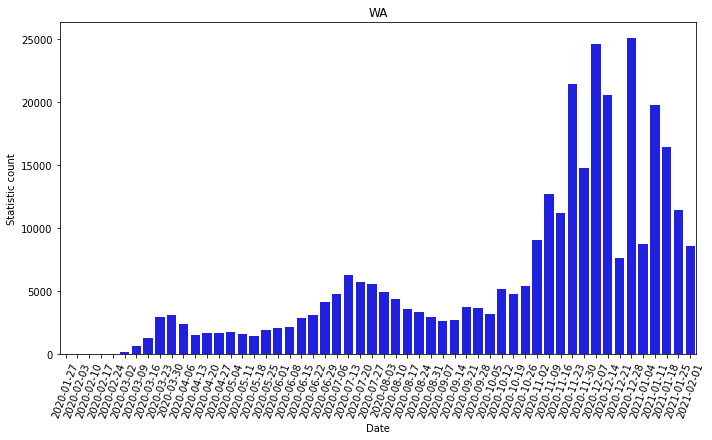

In [19]:
plot_state('WA', cases_state_sum)

# Problem 2
Do those states follow the the same trends?

The states do follow similar trends. We see that they all have 3 sudden bumps in number of cases where cases rise and fall.
1. Mid March - The start of the coronavirus pandemic. This is less pronounced for California and might be due to it being one of the  first states to implement stay at home orders.
2. July - Possibly related to more people being outdoors due to summer breaks.
3. November to January - The holidays where people are less likely to be social distancing.



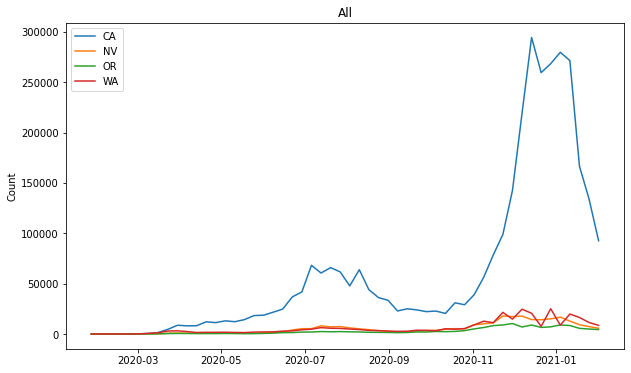

In [20]:
# Plot all new cases on same graph
# while this sort of plot is not the best for weekly aggregate 
# data, it allows us to see trends
plot_state('CA', cases_state_sum, 'multi')
plot_state('NV', cases_state_sum, 'multi')
plot_state('OR', cases_state_sum, 'multi')
plot_state('WA', cases_state_sum, 'multi')

# Problem 3
Plot the weekly number of covid deaths in the following states: California, Oregon, Washington, and Nevada.

In [28]:
deaths_state_sum = weekly_sum(deaths_df)
deaths_state_sum.loc[['CA', 'NV', 'OR', 'WA']] # give a sample of ALL the data

,2020-01-27,2020-02-03,2020-02-10,2020-02-17,2020-02-24,2020-03-02,2020-03-09,2020-03-16,2020-03-23,2020-03-30,...,2020-11-30,2020-12-07,2020-12-14,2020-12-21,2020-12-28,2021-01-04,2021-01-11,2021-01-18,2021-01-25,2021-02-01
State,,,,,,,,,,,,,,,,,,,,,
CA,0,1,0,1,0,2,5,27,99,217,...,781,1095,1640,1552,2318,3163,3691,3398,3907,3245
NV,0,0,0,0,0,0,0,2,13,31,...,167,217,205,192,223,262,302,238,238,248
OR,0,0,0,0,0,0,1,3,9,14,...,128,104,165,113,62,98,183,107,73,64
WA,0,0,0,0,1,18,23,52,101,143,...,137,47,224,28,314,190,210,272,171,164


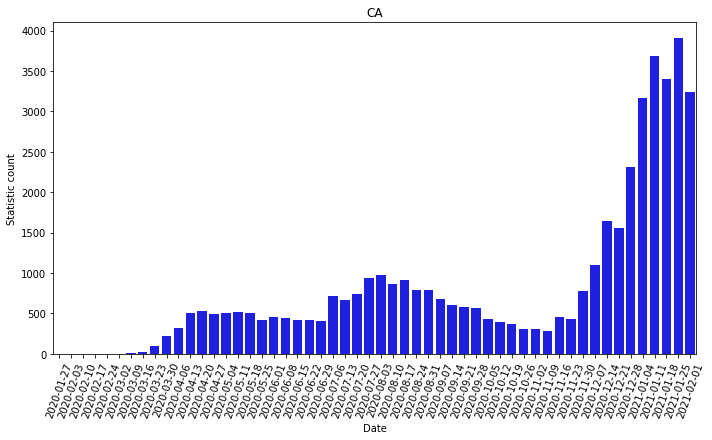

In [29]:
plot_state('CA', deaths_state_sum)

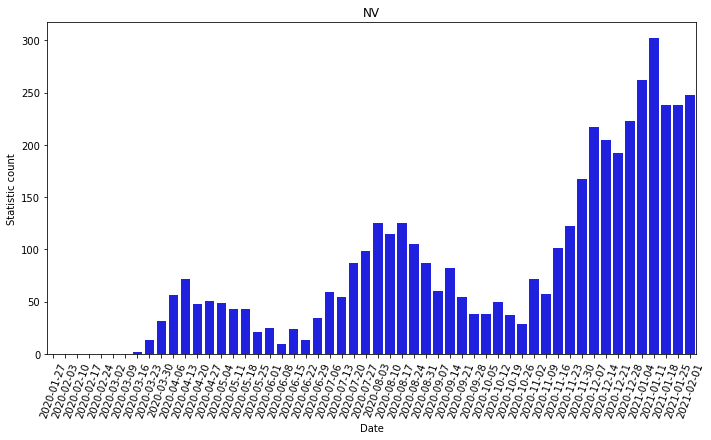

In [30]:
plot_state('NV', deaths_state_sum)

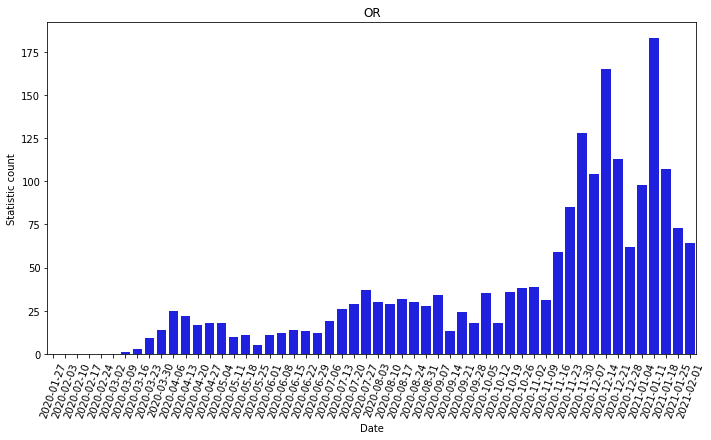

In [31]:
plot_state('OR', deaths_state_sum)

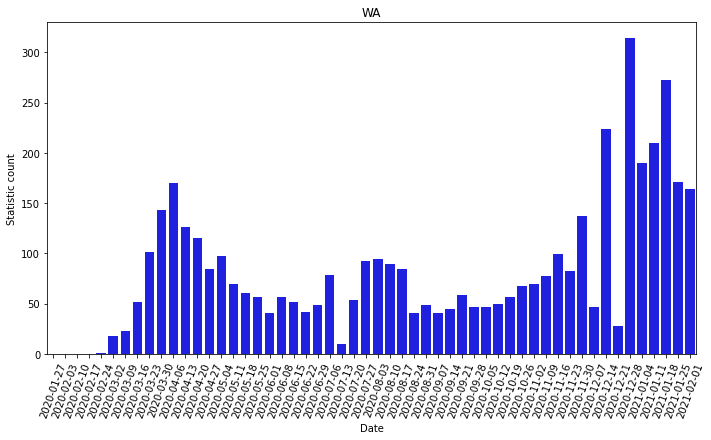

In [32]:
plot_state('WA', deaths_state_sum)

# Problem 4
How do the deaths and the new cases compare?

We can see that the data for deaths does seem to correlate to the data for new cases. In particular, we see the same 3 bumps as before. Although the count of deaths is much less for each state, the trend is about the same. However, Washington seems to have a very large number of deaths in the first uptick (March) as compared to the trends of other states.

All in all, the graphs appear to be very similar albeit scaled up/down for deaths vs cases.

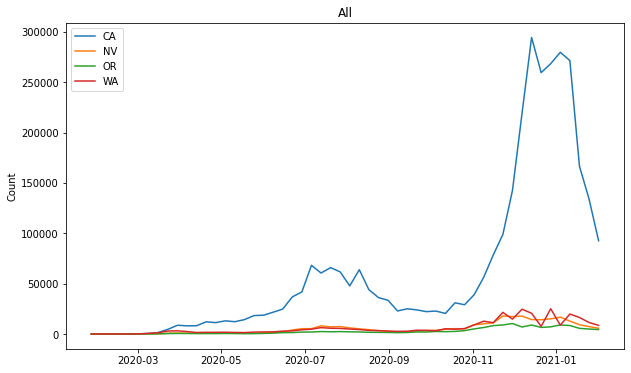

In [33]:
# Plot all new cases on same graph
# while this sort of plot is not the best for weekly aggregate 
# data, it allows us to see trends
plot_state('CA', cases_state_sum, 'multi')
plot_state('NV', cases_state_sum, 'multi')
plot_state('OR', cases_state_sum, 'multi')
plot_state('WA', cases_state_sum, 'multi')

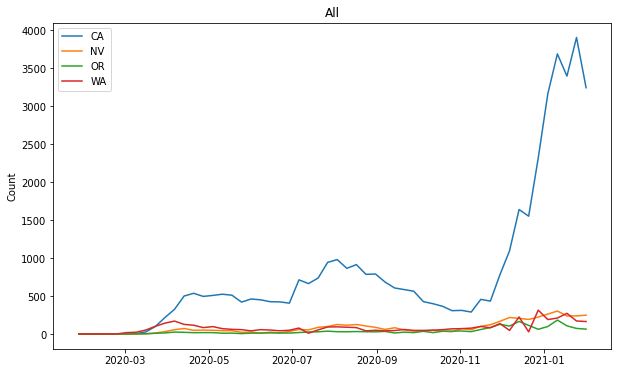

In [34]:
# Plot all deaths on same graph
# while this sort of plot is not the best for weekly aggregate 
# data, it allows us to see trends
plot_state('CA', deaths_state_sum, 'multi')
plot_state('NV', deaths_state_sum, 'multi')
plot_state('OR', deaths_state_sum, 'multi')
plot_state('WA', deaths_state_sum, 'multi')

# Problem 5
Compute the number of new covid cases per 100,000 population in each county per week.
What are the 20 highest rates achieved. Show the date, county and the rate.

In [35]:
def get_clean_county_pop(pop_df):
    """Takes in a raw population dataframe object and returns it cleaned up.
    input   dataframe of populations of format:
            index=[None], keys=[countyFIPS, County Name, State, Population]
    returns dataframe with nonzero populations. That Dataframe is of format:  
                index=[countyFIPS], keys=[County Name, population]
    """
    pop_df = pop_df.set_index(['countyFIPS'])
    pop_df.drop(['State'], axis=1) # remove unneeded columns
    pop_df.drop(index=0, inplace=True, axis=1) # drop "State unallocated" items
    pop_df.drop(pop_df.loc[pop_df['population']==0].index, inplace=True) # any county with 0 population should not be counted
    return pop_df

In [36]:
def get_clean_statistic_data(statistic_df):
    """Takes in a raw statistic(deaths/cases daily aggregate values) dataframe object and 
       returns it cleaned up. Returned data is grouped by weekly sums (M-Sun).
    input   dataframe of statistic of format:
                index=[None], keys=[countyFIPS, County Name, State, StateFIPS, Cases by date, ...]
    returns dataframe with nonzero statistic. That Dataframe is of format:  
                index=[countyFIPS], keys=[Cases grouped by week(sum), ...]
    """
    weekly_data = weekly_sum(statistic_df, 'countyFIPS') # get the weekly statistic data with index=countyFIPS
    weekly_data.drop(index=0, inplace=True, axis=1) # we can drop statewide unallocated data (countyFIPS=0)
    
    # if we wanted to get rid of negative case values, we could use the mask below
    #neg_mask = cases_by_county_weekly < 0 | cases_by_county_weekly.isnull()
    #cases_by_county_weekly[neg_mask] = 0
    return weekly_data

In [37]:
# constants and dataframe we will reuse
TOP_N = 20
PER_N_PERSONS = 100000
county_pop = get_clean_county_pop(pop_df) # get population by county with index=countyFIPS

### Weekly case rate by county:

In [41]:
cases_by_county_weekly = get_clean_statistic_data(cases_df) # get new cases by county with index=countyFIPS

# countyFIPS should be unique to each county even if they have the same name
cases_pop_county = county_pop.merge(cases_by_county_weekly, on='countyFIPS', how='outer')

# get rate of cases
cases_pop_county.iloc[:,NON_NUMERIC_COLS:] = cases_pop_county.iloc[:,NON_NUMERIC_COLS:].div(cases_pop_county.population, axis=0) # get the rate of cases per person
cases_pop_county.iloc[:,NON_NUMERIC_COLS:] = cases_pop_county.iloc[:,NON_NUMERIC_COLS:].multiply(PER_N_PERSONS, axis=0) # get rate of cases per 100,000 people

# we want to show by county name, reindex
cases_pop_county.set_index('County Name', inplace=True)

# get the N largest number of new cases per population by county
largest_cases = cases_pop_county.iloc[:, NON_NUMERIC_COLS:].stack().nlargest(TOP_N)
largest_cases = largest_cases.to_frame('Cases/'+str(PER_N_PERSONS)+' (Descending)').reset_index(level=0)
largest_cases.index.name = 'Date'

display(largest_cases)

,County Name,Cases/100000 (Descending)
Date,,
2020-04-27 00:00:00,Trousdale County,11503.013116
2020-08-10 00:00:00,Lafayette County,10009.498931
2021-01-18 00:00:00,Forest County,9134.814406
2020-11-02 00:00:00,Childress County,8335.614563
2020-11-09 00:00:00,Crowley County,7688.500247
2020-12-28 00:00:00,Pershing County,7315.985130
2020-11-30 00:00:00,Lincoln County,7314.506227
2020-08-31 00:00:00,Wayne County,7047.322018
2020-12-21 00:00:00,Crockett County,6033.487298


# Problem 6
Compute the number of covid deaths per 100,000 population in each county per week.
What are the 20 highest rates achieved. Show the date, county and the rate.

### Weekly death rate by county:

In [42]:
deaths_by_county_weekly = get_clean_statistic_data(deaths_df)

# countyFIPS should be unique to each county even if they have the same name
deaths_pop_county = county_pop.merge(deaths_by_county_weekly, on='countyFIPS', how='outer')

# get rate of cases
deaths_pop_county.iloc[:,NON_NUMERIC_COLS:] = deaths_pop_county.iloc[:,NON_NUMERIC_COLS:].div(deaths_pop_county.population, axis=0) # get the rate of cases per person
deaths_pop_county.iloc[:,NON_NUMERIC_COLS:] = deaths_pop_county.iloc[:,NON_NUMERIC_COLS:].multiply(PER_N_PERSONS, axis=0) # get rate of cases per 100,000 people

# we want to show by county name, reindex
deaths_pop_county.set_index('County Name', inplace=True)

# get the N largest number of deaths per population by county
largest_deaths = deaths_pop_county.iloc[:, NON_NUMERIC_COLS:].stack().nlargest(TOP_N)
largest_deaths = largest_deaths.to_frame('Deaths/'+str(PER_N_PERSONS)+' (Descending)').reset_index(level=0)
largest_deaths.index.name = 'Date'

display(largest_deaths)

,County Name,Deaths/100000 (Descending)
Date,,
2021-01-25 00:00:00,O'Brien County,414.455028
2020-10-12 00:00:00,Gove County,341.426404
2021-01-25 00:00:00,Rush County,329.380764
2021-02-01 00:00:00,Borden County,305.810398
2020-10-19 00:00:00,Jerauld County,298.062593
2020-11-23 00:00:00,Foster County,280.373832
2020-11-02 00:00:00,Gove County,265.553869
2020-11-30 00:00:00,Renville County,257.842716
2020-07-27 00:00:00,Kenedy County,247.524752


# Problem 7
What is the relation between the results in #5 and #6.

In [43]:
# set up for comparing death and cases rates
# drop '(Descending)' from column name
copy_cases = largest_cases.copy().rename(columns={'Cases/'+str(PER_N_PERSONS)+' (Descending)': 'Cases/'+str(PER_N_PERSONS)})
copy_deaths = largest_deaths.copy().rename(columns={'Deaths/'+str(PER_N_PERSONS)+' (Descending)': 'Deaths/'+str(PER_N_PERSONS)})

copy_cases = copy_cases.reset_index()
copy_deaths = copy_deaths.reset_index()

copy_cases = copy_cases.set_index(['County Name'])
copy_deaths = copy_deaths.set_index(['County Name'])

Value wise, they seem to correlate well. With growth being slow at first, then getting larger more quickly towards the top. Even the highest rate is twice the lowest (20th) rate for both. 

In other words, they have similar growth trends. However, those counties with highest case rates don't really show up in the highest deaths rate. Only Wayne County shows up on both, and it's months apart:

In [44]:
display(copy_cases.merge(copy_deaths, on='County Name'))

,Date_x,Cases/100000,Date_y,Deaths/100000
County Name,,,,
Wayne County,2020-08-31,7047.322018,2020-12-07,217.357553


Although, we do see some trends in the data by date, there isn't a strong correlation between highest rate of deaths and highest rate of new cases (at least for the top 20). We do see a trend where early in 2021, there was a spike in cases and deaths. However, compared to early 2020, there is only a spike in cases, not deaths. If we had a larger pool (top N rates) to look at, we may see some counties show up on boths top N lists.

In [45]:
# outer merge the two datafreames and sort by date 
display(copy_cases.merge(copy_deaths, on=['County Name', 'Date'], how='outer').sort_values('Date'))

,Date,Cases/100000,Deaths/100000
County Name,,,
Trousdale County,2020-04-27,11503.013116,NaN
Lee County,2020-06-08,5724.285876,NaN
Kenedy County,2020-07-27,NaN,247.524752
Perkins County,2020-08-03,NaN,207.540643
Lafayette County,2020-08-10,10009.498931,NaN
Wayne County,2020-08-31,7047.322018,NaN
Kenedy County,2020-09-21,NaN,247.524752
Gove County,2020-10-12,NaN,341.426404
Jerauld County,2020-10-19,NaN,298.062593


# Problem 8
Find the week that each county achieved their highest rate of new covid cases per 100,000
population. If a county reach the peak multiple ties pick the earliest one. Plot via a bar chart
the number of countries that reached their peak each week. What does the plot indicate
about the pandemic?

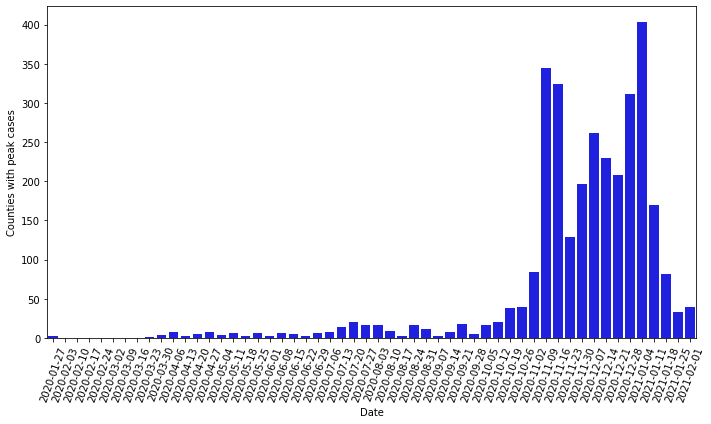

In [46]:
# get the index of value of the max rate of new cases per county
s = cases_pop_county
s = s.iloc[:,NON_NUMERIC_COLS-1:]
max_indexes = s.idxmax(axis=1) # dates are sorted, idxmax will use the first one if a tie
counts = max_indexes.value_counts() # get counts of each week that has a county with highest index

# fill in the missing weeks with 0 value
counts = counts.sort_index()
idx = pd.date_range(min(counts.index), max(counts.index))
counts = counts.reindex(idx, fill_value=0).resample('W-MON', label='left', closed='left').sum()
counts.index = counts.index.date # strip off time from the weeks

#plot
plt.figure(figsize=FIG_SIZE)
plot = sns.barplot(x=counts.index, y=counts.values, color='blue', ci=None) # remove ci=None to add back the confidence interval
plot.set(xlabel = 'Date', ylabel = 'Counties with peak cases')
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

It seems that almost all counties achieved their peak number of new covid cases between late October to mid January. This might indicate that most people were not social distancing during the holidays. It might also indicate that early on, more people were more serious about social distancing and more cautious. Perhaps they've grown tired of having to social distance and aren't being as cautious.

This could also show that the virus is, well... viral. Spreading exponentially if given the chance to. In other words, it's very contagious. 

# Problem 9
Compute the total number of covid cases in each county and the number of covid deaths.
Compute the percent of the population in each county that is still alive and has had covid.
Show the top 20 rates. Is any county getting close to herd immunity, that is 70% or more
people immune?

In [47]:
county_cases_sum = cases_by_county_weekly.sum(axis=1)
county_deaths_sum = deaths_by_county_weekly.sum(axis=1)

# combine the total cases and deaths to a dataframe
frame = {'Total Cases': county_cases_sum, 'Total Deaths': county_deaths_sum}
aggregate = pd.DataFrame(frame)
aggregate = aggregate.merge(county_pop, on='countyFIPS', how='outer')
aggregate.set_index(['County Name'], inplace=True)
aggregate.drop(['State'], axis=1, inplace=True)

# immune = total_cases - total_deaths
aggregate['Alive after contracting'] = aggregate.iloc[:, 0].sub(aggregate.iloc[:, 1])
# % pop immune = (immmune/population) * 100
aggregate['Population Immune %'] = aggregate.iloc[:, 3].div(aggregate.iloc[:, 2])*100

display(aggregate[['Population Immune %']].sort_values('Population Immune %', ascending=False).head(TOP_N))

,Population Immune %
County Name,
Crowley County,30.869493
Bent County,23.471400
Lincoln County,23.402948
Lake County,23.289624
Dewey County,23.234895
Chattahoochee County,22.765197
Norton County,21.936206
Bon Homme County,21.373714
Buffalo County,20.744139


Based on the above, no county has herd immunity. For that to occur, 70% of the population would have had to have contracted AND there not have been any deaths. If the death rate of a county is 1%, then (num_cases*0.99)/total_pop > 0.7 needs to hold. Or, num_cases > (0.7/0.99) num_pop which means ~70.7070% of that county needs to have contracted the virus. In other words, we need at least 70% of the population to have contracted it, and as the death rate goes up, so must the contracted rate (up until the death rate reaches 30%, after which herd immunity is not possible).

It does seem that Crowley County has a much higher immunity than other counties. However, if we check their how their statistics compare to other states, we find that they are below the median and average of total cases, total deaths, and population. Their small size makes any additional case or death skew the data significantly (relatively to other counties).

In [48]:
frame = {'Crowley County': aggregate.loc['Crowley County'], \
         'Average': aggregate.mean(), \
         'Median': aggregate.median()}
df = pd.DataFrame(frame)
display(df.T)

,Total Cases,Total Deaths,population,Alive after contracting,Population Immune %
Crowley County,1885.000000,14.000000,6061.000000,1871.000000,30.869493
Average,8418.996181,144.278167,104468.339593,8274.718014,8.259822
Median,2109.000000,37.000000,25726.000000,2068.500000,8.243526


# Problem 10
Produce a Violin and box plots of all the values computed in #8. What do the plots show
about the pandemic in the USA?

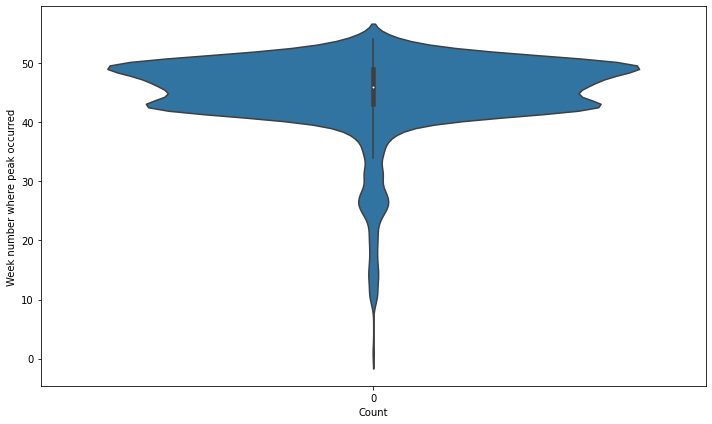

In [49]:
counts_cp = counts.copy().reset_index()
counts_cp.columns = ('Date_Col', 'Counts')

# label weeks by index (1 -> number_of_weeks)
counts_cp = counts_cp.sort_values('Date_Col')
counts_cp['Week'] = counts_cp.index+1
counts_cp.drop(['Date_Col'], axis=1, inplace=True)

# unfortunately, I could not find a clean way to aggregate. I create a dataframe
# holding one record for each week that had a peak. eg. if 3 counties had peaks in
# week 4, then 4 appears 3 times in the weeks_of_peak dataframe 
weeks_of_peak = pd.DataFrame()
for i in counts_cp.values: # i is the (count_per_week, week) pair
    for j in range(i[0]):
        weeks_of_peak = weeks_of_peak.append(pd.DataFrame({i[1]}))

# plot violim
plt.figure(figsize=FIG_SIZE)
plot1 = sns.violinplot(data=weeks_of_peak)
plot1.set(xlabel = 'Count', ylabel = 'Week number where peak occurred')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

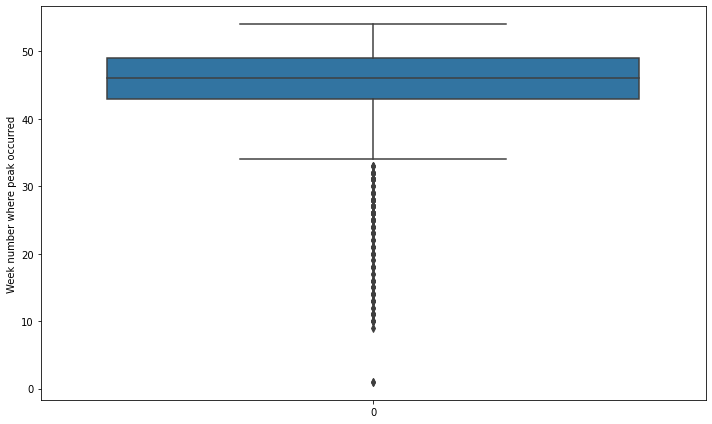

In [50]:
#plot boxplot
plt.figure(figsize=FIG_SIZE)
plot1 = sns.boxplot(data=weeks_of_peak)
plot1.set(ylabel = 'Week number where peak occurred')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

The plots above indicate that at least in the USA, we were not social distancing over the holidays and this made things much worse. This is evident with the heavily grouped data around weeks 42-48 (holidays) and then a stark drop after that. We know that the virus is very contagious, so the stark drop off is best described by the fact that holidays were over and people were social distancing again. Otherwise, we would continue to see peak number of new cases each week, which is not the case.